# TTC Subway Delay Data — Preprocessing & Exploratory Analysis

**Author:** Suha Islaih  
**Date:** February 2026  
**Dataset:** Toronto Transit Commission (TTC) subway delay records, 2024–2025  

## Objective

Prepare TTC subway delay data for a regression model that predicts **delay duration in minutes** for a given line, station, time, and day.

## Approach

| Step | Description |
|------|-------------|
| **1. Data Loading** | Combine 2024 (Excel) and 2025 (CSV) delay records into a single dataset |
| **2. Data Cleaning** | Standardize line names, remove invalid records, handle outliers, drop irrelevant columns |
| **3. Feature Engineering** | Extract temporal features, compute historical average delays per route/time |
| **4. Correlation Analysis** | Identify data leakage, multicollinearity, and useful predictors |
| **5. Exploratory Data Analysis** | Visualize delay patterns by time, day, line, station, and incident code |
| **6. Export** | Save the cleaned dataset for model training |

## Target Variable

`min_delay_capped` — delay in minutes, capped at 60 to mitigate extreme outliers.

---

## 1. Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

In [2]:
df_2024 = pd.read_excel('../data/raw/ttc-subway-delay-2024.xlsx', sheet_name='Subway')
df_2025 = pd.read_csv('../data/raw/ttc-subway-delay-data-since-2025.csv')

df = pd.concat([df_2024, df_2025], ignore_index=True)
print(f"Combined dataset: {df.shape[0]:,} records, {df.shape[1]} columns")
df.head()

Combined dataset: 52,180 records, 11 columns


,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,_id
0,2024-01-01 00:00:00,02:00,Monday,SHEPPARD STATION,MUI,0,0,N,YU,5491,NaN
1,2024-01-01 00:00:00,02:00,Monday,DUNDAS STATION,MUIS,0,0,N,YU,0,NaN
2,2024-01-01 00:00:00,02:08,Monday,DUNDAS STATION,MUPAA,4,10,N,YU,6051,NaN
3,2024-01-01 00:00:00,02:13,Monday,KENNEDY BD STATION,PUTDN,10,16,E,BD,5284,NaN
4,2024-01-01 00:00:00,02:22,Monday,BLOOR STATION,MUPAA,4,10,N,YU,5986,NaN


In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 52180 entries, 0 to 52179
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       52180 non-null  object 
 1   Time       52180 non-null  str    
 2   Day        52180 non-null  str    
 3   Station    52180 non-null  str    
 4   Code       52180 non-null  str    
 5   Min Delay  52180 non-null  int64  
 6   Min Gap    52180 non-null  int64  
 7   Bound      33198 non-null  str    
 8   Line       52069 non-null  str    
 9   Vehicle    52180 non-null  int64  
 10  _id        25713 non-null  float64
dtypes: float64(1), int64(3), object(1), str(6)
memory usage: 4.4+ MB


---
## 2. Data Cleaning

### 2.1 Standardize Line Names

The `Line` column contains **30 unique variations** of line names due to inconsistent data entry. We map all variations to canonical forms and flag invalid entries (bus routes logged as subway).

In [4]:
print(f"Unique Line values before cleaning: {df['Line'].nunique()}")
df['Line'].value_counts()

Unique Line values before cleaning: 29


Line
YU                        27221
BD                        22133
SHP                        1955
YU/BD                       655
YUS/BD                       24
YU/ BD                       20
YUS                          11
YU / BD                      11
BD/YU                         7
YU & BD                       6
SRT                           3
BD/YUS                        3
YU/BD/SHP                     2
YUS / BD                      2
YU/BD LINES                   2
BLOOR DANFORTH                1
SHEP                          1
LINE 1                        1
TRACK LEVEL ACTIVITY          1
109 RANEE                     1
ONGE-UNIVERSITY AND BL        1
BD/ YUS                       1
BD/ YU                        1
BD / YU                       1
20 CLIFFSIDE                  1
YUS/ BD                       1
YUS/ BD/ SHP                  1
YU -BD LINES                  1
29 DUFFERIN                   1
Name: count, dtype: int64

In [5]:
line_mapping = {
    # Line 1 — Yonge-University
    'YU': 'Line 1', 'YUS': 'Line 1', 'LINE 1': 'Line 1',
    # Line 2 — Bloor-Danforth
    'BD': 'Line 2', 'BLOOR DANFORTH': 'Line 2',
    # Line 4 — Sheppard
    'SHP': 'Line 4', 'SHEP': 'Line 4',
    # Line 3 — Scarborough RT (decommissioned 2023)
    'SRT': 'Line 3',
    # Multi-line: Line 1 / Line 2
    'YU/BD': 'Line 1/2', 'YU/ BD': 'Line 1/2', 'YU / BD': 'Line 1/2',
    'YU & BD': 'Line 1/2', 'YU/BD LINES': 'Line 1/2', 'YU -BD LINES': 'Line 1/2',
    'BD/YU': 'Line 1/2', 'BD/ YU': 'Line 1/2', 'BD / YU': 'Line 1/2',
    'YUS/BD': 'Line 1/2', 'YUS / BD': 'Line 1/2', 'YUS/ BD': 'Line 1/2',
    'BD/YUS': 'Line 1/2', 'BD/ YUS': 'Line 1/2', 'ONGE-UNIVERSITY AND BL': 'Line 1/2',
    # Multi-line: Line 1 / Line 2 / Line 4
    'YU/BD/SHP': 'Line 1/2/4', 'YUS/ BD/ SHP': 'Line 1/2/4',
    # Invalid — bus routes and non-subway entries
    '109 RANEE': None, '20 CLIFFSIDE': None, '29 DUFFERIN': None, 'TRACK LEVEL ACTIVITY': None,
}

df['Line'] = df['Line'].map(line_mapping)
print(f"Unique Line values after mapping: {df['Line'].dropna().nunique()}")
df['Line'].value_counts()

Unique Line values after mapping: 6


Line
Line 1        27233
Line 2        22134
Line 4         1956
Line 1/2        736
Line 3            3
Line 1/2/4        3
Name: count, dtype: int64

### 2.2 Remove Invalid Records

Rows with null `Line` values include the original 111 nulls and the 4 invalid entries mapped to `None`. A single `dropna()` handles both.

In [6]:
records_before = len(df)
df = df.dropna(subset=['Line'])
print(f"Removed {records_before - len(df)} invalid records ({records_before:,} -> {len(df):,})")

Removed 115 invalid records (52,180 -> 52,065)


### 2.3 Cap Outliers

The raw `Min Delay` column has extreme outliers (max 900 min). We cap at 60 minutes to create the regression target — this preserves 99.8% of the data distribution.

In [7]:
print(f"Before capping — Max: {df['Min Delay'].max()} min, Records > 60 min: {(df['Min Delay'] > 60).sum()}")
df['min_delay_capped'] = df['Min Delay'].clip(upper=60)
print(f"After capping  — Max: {df['min_delay_capped'].max()} min")

Before capping — Max: 900 min, Records > 60 min: 124
After capping  — Max: 60 min


### 2.4 Drop Irrelevant Columns

| Column | Reason for dropping |
|--------|--------------------|
| `_id` | Database identifier, 50% null, no predictive value |
| `Vehicle` | Fleet number — individual vehicles don't consistently cause delays |
| `Bound` | 36% null, not needed for Phase 1 |
| `Time` | Will be replaced by extracted `hour` feature |
| `Day` | Will be replaced by extracted `day_of_week` feature |

In [8]:
df = df.drop(columns=['_id', 'Vehicle', 'Bound'])
print(f"Remaining columns: {df.columns.tolist()}")

Remaining columns: ['Date', 'Time', 'Day', 'Station', 'Code', 'Min Delay', 'Min Gap', 'Line', 'min_delay_capped']


---
## 3. Feature Engineering

### 3.1 Temporal Features

Extract structured time components from `Date` and `Time` columns.

In [9]:
# Extract hour from Time column (HH:MM -> int)
df['hour'] = df['Time'].apply(lambda t: int(t.split(':')[0]))
df = df.drop(columns=['Time'])

# Parse Date and extract temporal components
df['Date'] = pd.to_datetime(df['Date'])
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['week'] = df['Date'].dt.isocalendar().week

# Day of week (0=Monday, 6=Sunday) and weekend indicator
day_mapping = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
df['day_of_week'] = df['Day'].map(day_mapping)
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df = df.drop(columns=['Day'])

print("Temporal features created:")
df[['Date', 'hour', 'year', 'month', 'week', 'day_of_week', 'is_weekend']].head()

Temporal features created:


,Date,hour,year,month,week,day_of_week,is_weekend
0,2024-01-01,2,2024,1,1,0,0
1,2024-01-01,2,2024,1,1,0,0
2,2024-01-01,2,2024,1,1,0,0
3,2024-01-01,2,2024,1,1,0,0
4,2024-01-01,2,2024,1,1,0,0


In [10]:
# Validate temporal features
for col, expected in [('hour', (0, 23)), ('day_of_week', (0, 6)), ('month', (1, 12)), ('week', (1, 53)), ('year', (2024, 2025))]:
    assert df[col].min() >= expected[0] and df[col].max() <= expected[1], f"{col} out of range"
    assert df[col].isnull().sum() == 0, f"{col} has nulls"
print("All temporal features validated.")

All temporal features validated.


### 3.2 Historical Average Delay Features

Since we're predicting delay in minutes (regression), we compute **average delay** per group rather than binary delay frequency. Three levels of granularity:

1. `route_avg_delay` — average delay by Line
2. `route_hour_avg_delay` — average delay by Line + Hour
3. `route_day_hour_avg_delay` — average delay by Line + Day + Hour

In [11]:
# Route-level average delay
route_avg = df.groupby('Line')['min_delay_capped'].mean()
df['route_avg_delay'] = df['Line'].map(route_avg)

# Route + Hour average delay
route_hour_avg = df.groupby(['Line', 'hour'])['min_delay_capped'].mean()
df['route_hour_avg_delay'] = df.set_index(['Line', 'hour']).index.map(route_hour_avg)

# Route + Day + Hour average delay
route_day_hour_avg = df.groupby(['Line', 'day_of_week', 'hour'])['min_delay_capped'].mean()
df['route_day_hour_avg_delay'] = df.set_index(['Line', 'day_of_week', 'hour']).index.map(route_day_hour_avg)

print("Historical average delay features:")
for col in ['route_avg_delay', 'route_hour_avg_delay', 'route_day_hour_avg_delay']:
    print(f"  {col}: min={df[col].min():.2f}, max={df[col].max():.2f}, nulls={df[col].isnull().sum()}")

Historical average delay features:
  route_avg_delay: min=0.00, max=2.86, nulls=0
  route_hour_avg_delay: min=0.00, max=4.18, nulls=0
  route_day_hour_avg_delay: min=0.00, max=11.50, nulls=0


---
## 4. Correlation Analysis

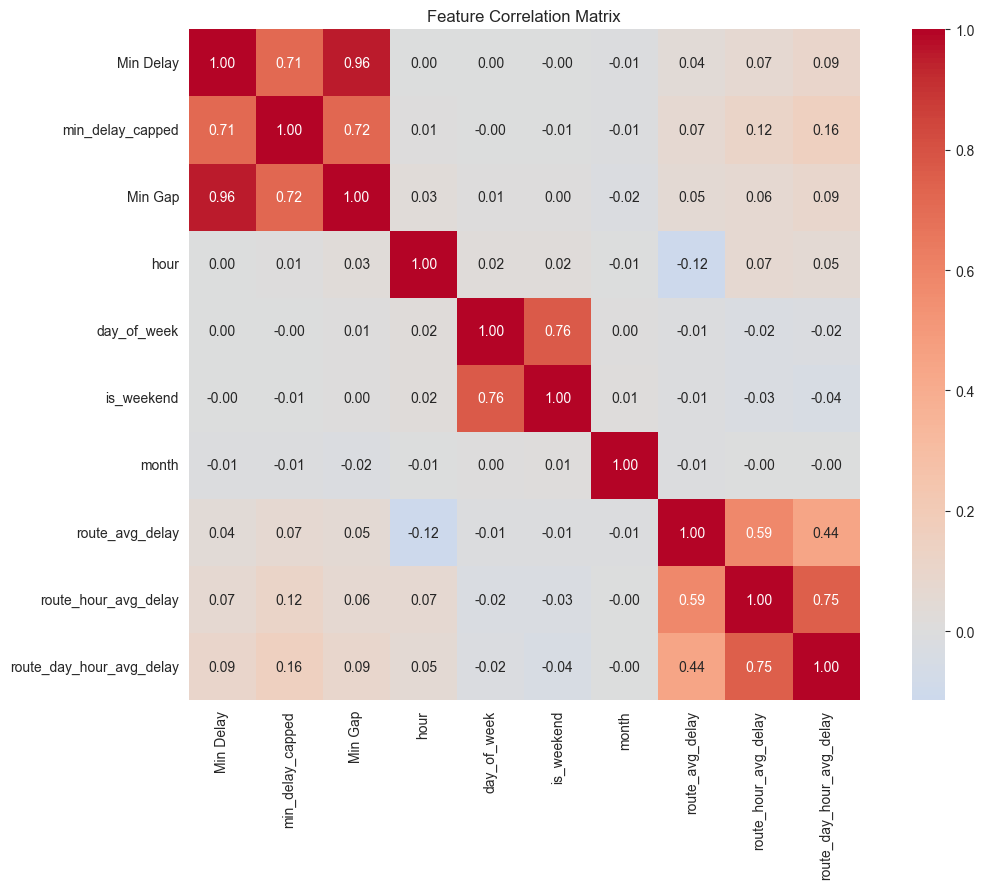


Correlation with target (min_delay_capped):
min_delay_capped            1.000000
Min Gap                     0.721737
Min Delay                   0.714891
route_day_hour_avg_delay    0.158244
route_hour_avg_delay        0.118621
route_avg_delay             0.069423
hour                        0.008338
day_of_week                -0.003663
is_weekend                 -0.006068
month                      -0.014143
Name: min_delay_capped, dtype: float64


In [12]:
numeric_cols = ['Min Delay', 'min_delay_capped', 'Min Gap', 'hour',
                'day_of_week', 'is_weekend', 'month',
                'route_avg_delay', 'route_hour_avg_delay', 'route_day_hour_avg_delay']

corr = df[numeric_cols].corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

print("\nCorrelation with target (min_delay_capped):")
print(corr['min_delay_capped'].sort_values(ascending=False))

### Correlation Findings

**Data leakage — must drop before training:**
- `Min Gap` (0.72) — gap is only known *after* the delay occurs
- `Min Delay` (0.71) — raw version of the target variable itself

**Useful predictive features:**
- `route_day_hour_avg_delay` (0.16) — best historical feature
- `route_hour_avg_delay` (0.12)
- `route_avg_delay` (0.07)

**Weak individual correlation (may help in combination):**
- `hour`, `day_of_week`, `is_weekend`, `month` — all near zero individually, but interact meaningfully (as the heatmap in the EDA section will show)

**Multicollinearity:**
- The three `route_*_avg_delay` features are correlated with each other (0.44–0.75). Consider keeping only `route_day_hour_avg_delay` to avoid redundancy.

In [13]:
# Drop leakage columns
df = df.drop(columns=['Min Delay', 'Min Gap'])
print(f"Final columns ({len(df.columns)}): {df.columns.tolist()}")

Final columns (14): ['Date', 'Station', 'Code', 'Line', 'min_delay_capped', 'hour', 'year', 'month', 'week', 'day_of_week', 'is_weekend', 'route_avg_delay', 'route_hour_avg_delay', 'route_day_hour_avg_delay']


---
## 5. Exploratory Data Analysis

### 5.1 Dataset Overview

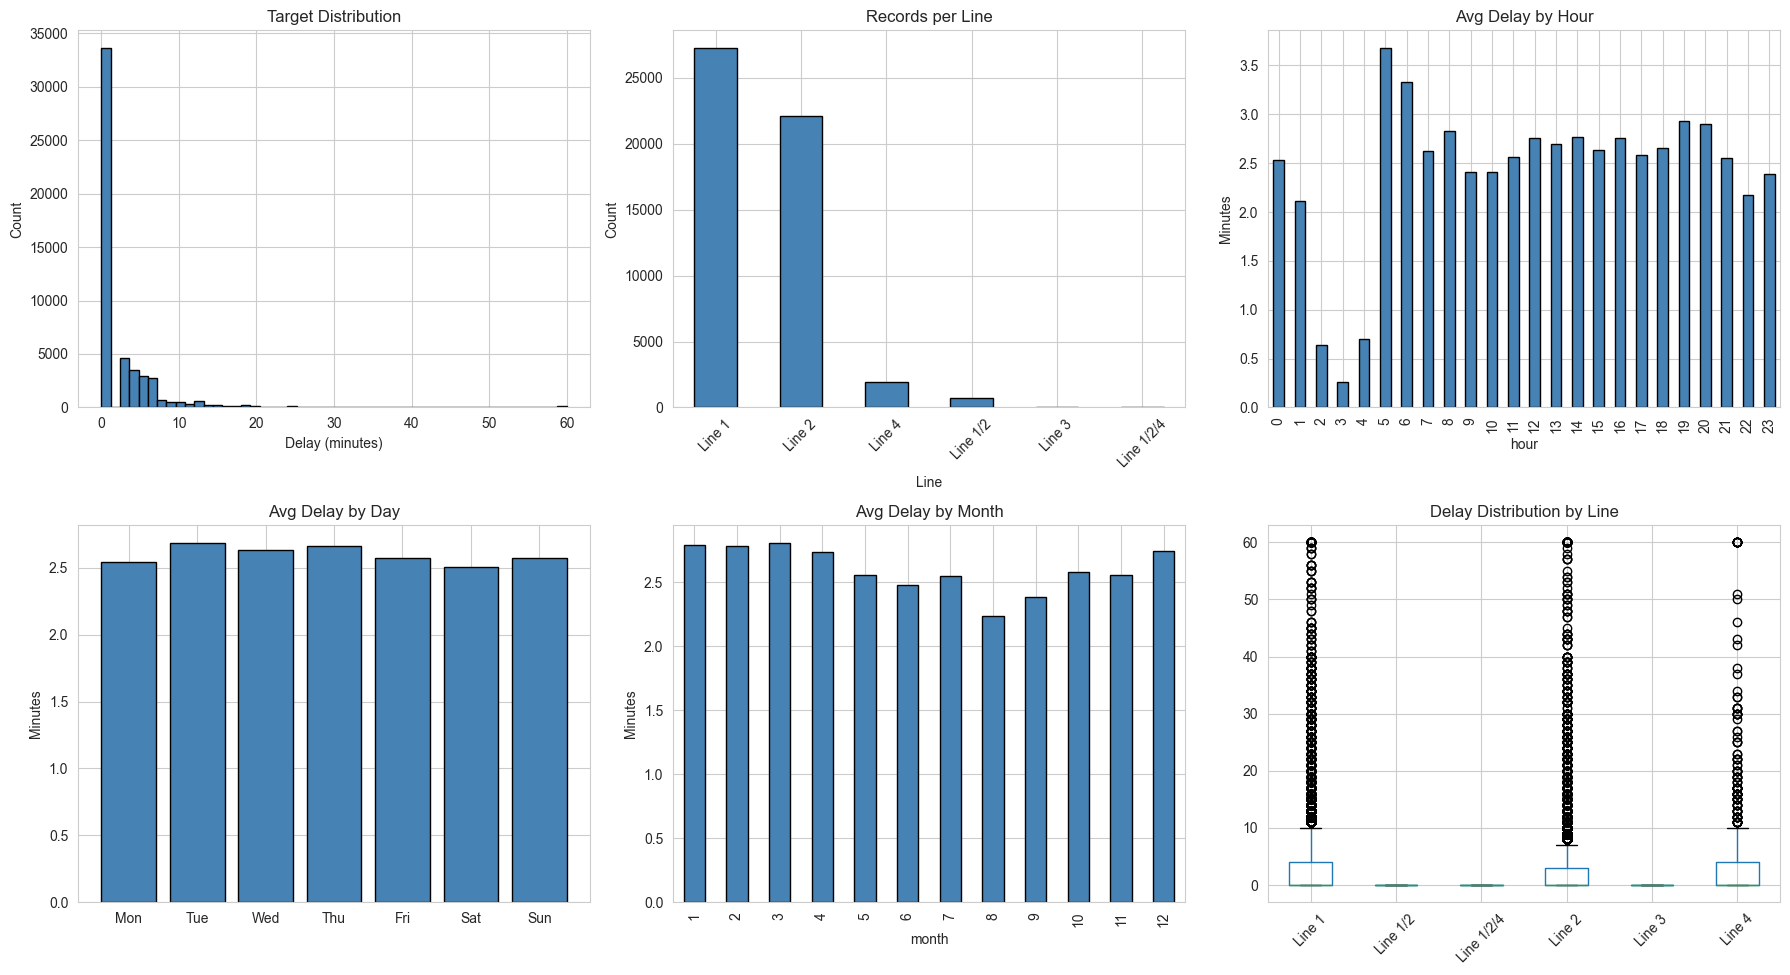

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Dataset Overview', fontsize=16, fontweight='bold')

# Target distribution
axes[0, 0].hist(df['min_delay_capped'], bins=50, edgecolor='black', color='steelblue')
axes[0, 0].set_title('Target Distribution')
axes[0, 0].set_xlabel('Delay (minutes)')
axes[0, 0].set_ylabel('Count')

# Records per line
df['Line'].value_counts().plot(kind='bar', ax=axes[0, 1], edgecolor='black', color='steelblue')
axes[0, 1].set_title('Records per Line')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)

# Average delay by hour
df.groupby('hour')['min_delay_capped'].mean().plot(kind='bar', ax=axes[0, 2], edgecolor='black', color='steelblue')
axes[0, 2].set_title('Avg Delay by Hour')
axes[0, 2].set_ylabel('Minutes')

# Average delay by day
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
day_avg = df.groupby('day_of_week')['min_delay_capped'].mean()
axes[1, 0].bar(days, day_avg.values, edgecolor='black', color='steelblue')
axes[1, 0].set_title('Avg Delay by Day')
axes[1, 0].set_ylabel('Minutes')

# Average delay by month
df.groupby('month')['min_delay_capped'].mean().plot(kind='bar', ax=axes[1, 1], edgecolor='black', color='steelblue')
axes[1, 1].set_title('Avg Delay by Month')
axes[1, 1].set_ylabel('Minutes')

# Box plot by line
df.boxplot(column='min_delay_capped', by='Line', ax=axes[1, 2], vert=True)
axes[1, 2].set_title('Delay Distribution by Line')
axes[1, 2].set_xlabel('')
axes[1, 2].tick_params(axis='x', rotation=45)
plt.suptitle('')

plt.tight_layout()
plt.show()

**Key observations:**
- **Target is zero-inflated:** 64.5% of records have zero delay. A two-stage model (classify delay/no-delay, then predict minutes) may outperform standard regression.
- **Line imbalance:** Line 1 and Line 2 account for 95% of records. Line 3 (3 records, decommissioned) and Line 1/2/4 (3 records) have insufficient data.
- **Temporal patterns:** Early morning (5-7am) shows peak delays; midday is stable; day-of-week has minimal impact.
- **Seasonal effect:** Winter months (Jan-Mar) show slightly higher delays than summer — possible weather correlation.

In [15]:
# Remove lines with insufficient data
df = df[~df['Line'].isin(['Line 3', 'Line 1/2/4'])]
print(f"After removing minority lines: {len(df):,} records")
print(df['Line'].value_counts())

After removing minority lines: 52,059 records
Line
Line 1      27233
Line 2      22134
Line 4       1956
Line 1/2      736
Name: count, dtype: int64


### 5.2 Delay Heatmap — Day of Week vs Hour

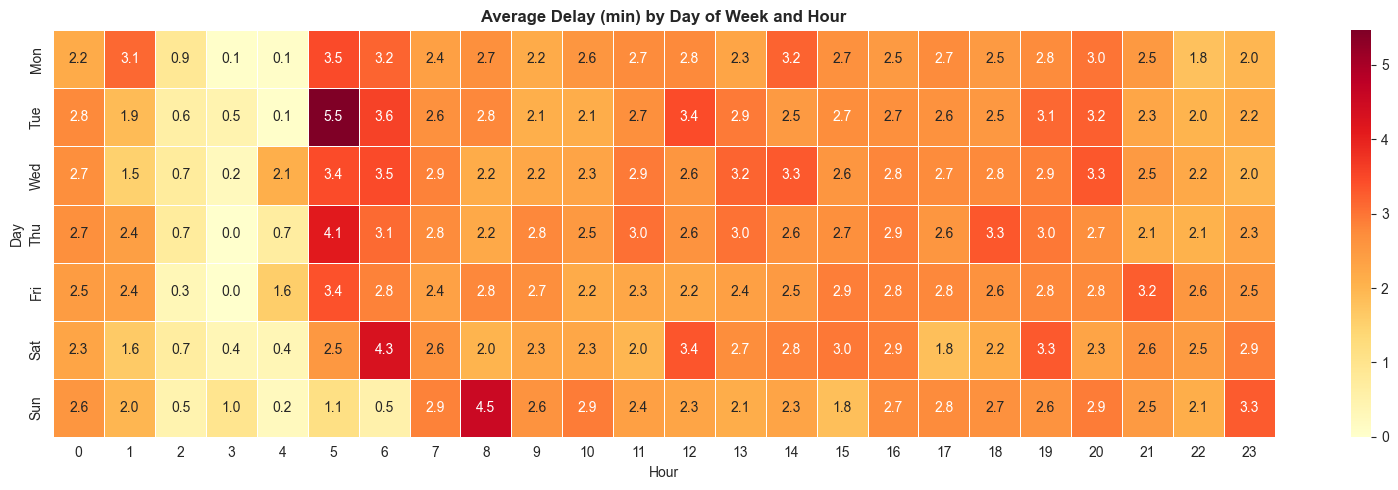

In [16]:
pivot = df.pivot_table(values='min_delay_capped', index='day_of_week', columns='hour', aggfunc='mean')
pivot.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(16, 5))
sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='.1f', linewidths=0.5)
plt.title('Average Delay (min) by Day of Week and Hour', fontweight='bold')
plt.xlabel('Hour')
plt.ylabel('Day')
plt.tight_layout()
plt.show()

**Findings:**
- **Peak hotspots:** Tuesday 5am (5.5 min), Sunday 8am (4.5 min), Saturday 6am (4.3 min) — early morning is consistently the worst period.
- **Low delay:** Hours 2-4 across all days (0.0-1.0 min) — minimal service, minimal delays.
- **Weekday vs weekend:** Weekday peaks at 5-6am (rush hour startup); weekend peaks shift later to 6-8am.
- **Modeling insight:** The hour + day_of_week interaction captures meaningful variation (0.0 to 5.5 min range), supporting their inclusion despite low individual correlations.

### 5.3 Top Stations & Delay Codes

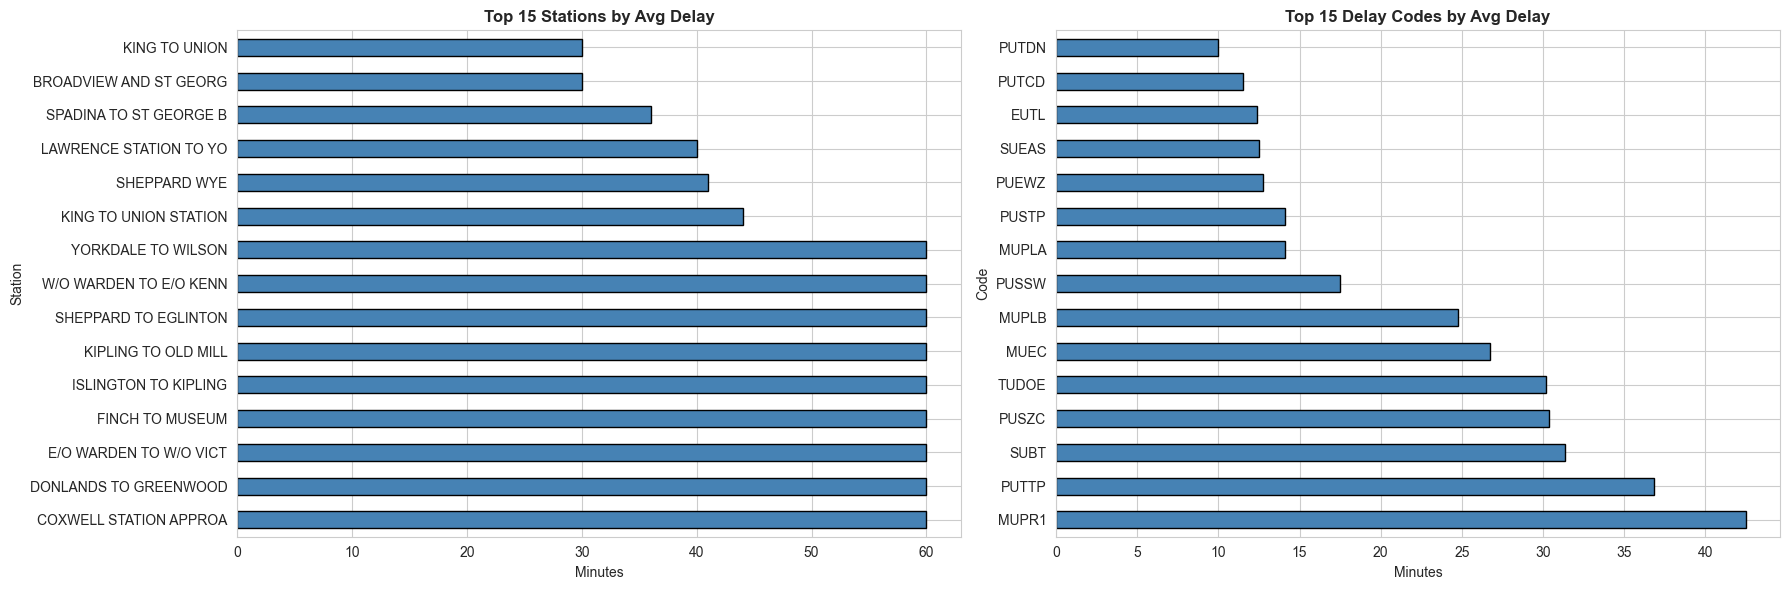

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

df.groupby('Station')['min_delay_capped'].mean().nlargest(15).plot(
    kind='barh', ax=axes[0], edgecolor='black', color='steelblue')
axes[0].set_title('Top 15 Stations by Avg Delay', fontweight='bold')
axes[0].set_xlabel('Minutes')

df.groupby('Code')['min_delay_capped'].mean().nlargest(15).plot(
    kind='barh', ax=axes[1], edgecolor='black', color='steelblue')
axes[1].set_title('Top 15 Delay Codes by Avg Delay', fontweight='bold')
axes[1].set_xlabel('Minutes')

plt.tight_layout()
plt.show()

**Findings:**
- **Stations:** The highest-delay locations are between-station segments (trains in transit), averaging 50-60 min — likely rare, severe incidents. Named stations appear lower (~30 min).
- **Codes:** `MUPR1` (~43 min), `PUTTP` (~38 min) are the worst. Codes starting with `PU` suggest power/utility issues; `MU` codes suggest mechanical failures.
- **Modeling insight:** `Code` carries strong predictive signal — top codes average 3-4x the dataset mean (2.8 min). Worth encoding despite 131 unique values.

### 5.4 Zero-Delay Analysis

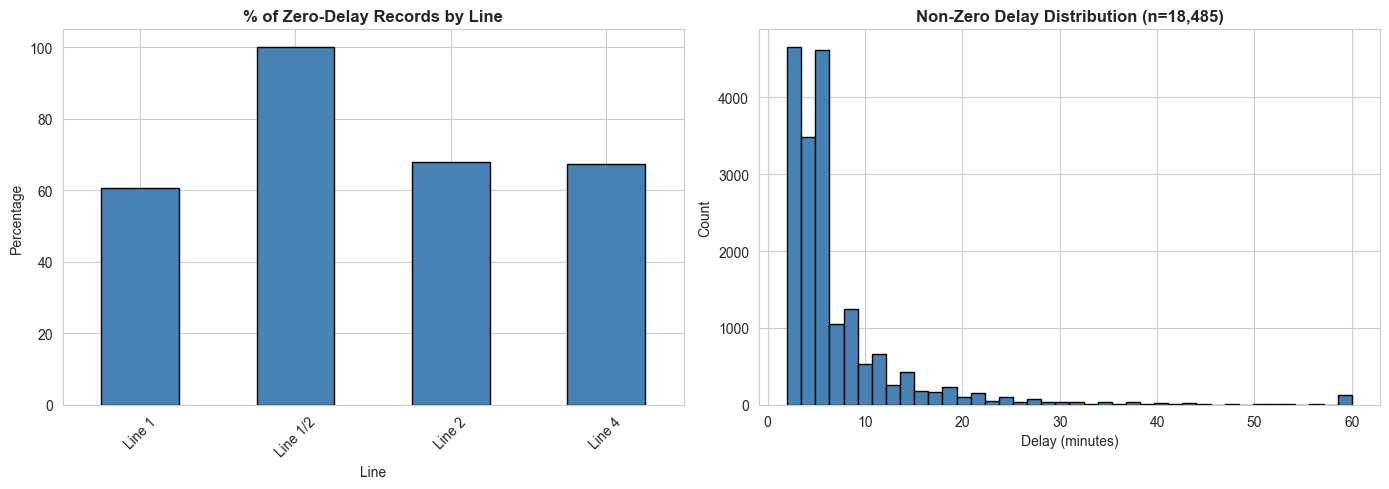

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Zero-delay percentage per line
zero_pct = df.groupby('Line')['min_delay_capped'].apply(lambda x: (x == 0).mean() * 100)
zero_pct.plot(kind='bar', ax=axes[0], edgecolor='black', color='steelblue')
axes[0].set_title('% of Zero-Delay Records by Line', fontweight='bold')
axes[0].set_ylabel('Percentage')
axes[0].tick_params(axis='x', rotation=45)

# Non-zero delay distribution
non_zero = df[df['min_delay_capped'] > 0]['min_delay_capped']
axes[1].hist(non_zero, bins=40, edgecolor='black', color='steelblue')
axes[1].set_title(f'Non-Zero Delay Distribution (n={len(non_zero):,})', fontweight='bold')
axes[1].set_xlabel('Delay (minutes)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

**Findings:**
- **Line 1/2:** 100% zero-delay — combined-line incidents are logged but never result in measured delay. Adds no predictive value for regression.
- **Lines 1, 2, 4:** 61-68% zero-delay — Line 1 has the best ratio of actual delays.
- **Non-zero distribution:** Most delays are 2-5 minutes with a sharp drop-off after 10 min. Small spike at 60 min from capped outliers.
- **Modeling insight:** A two-stage model — Stage 1 (classify delay/no-delay) trained on all records, Stage 2 (predict minutes) trained on the ~18,500 non-zero records — would leverage a much healthier distribution.

---
## 6. Validation & Export

In [19]:
# Select final columns
selected_columns = [
    'Date', 'Line', 'Station', 'Code',
    'hour', 'day_of_week', 'is_weekend',
    'month', 'week', 'year',
    'min_delay_capped',
    'route_avg_delay', 'route_hour_avg_delay', 'route_day_hour_avg_delay'
]

df_export = df[selected_columns]

In [21]:
# Validation summary
summary = pd.DataFrame({
    'dtype': df_export.dtypes,
    'nulls': df_export.isnull().sum(),
    'min': df_export.select_dtypes('number').min().reindex(df_export.columns),
    'max': df_export.select_dtypes('number').max().reindex(df_export.columns),
})
print(summary)
print(f"\nTotal records: {len(df_export):,}")
print(f"Date range: {df_export['Date'].min()} to {df_export['Date'].max()}")
print(f"Nulls: {df_export.isnull().sum().sum()}")
assert df_export.isnull().sum().sum() == 0, "Validation FAILED — nulls found"
print("\nValidation passed.")

                                   dtype  nulls     min       max
Date                      datetime64[us]      0    <NA>      <NA>
Line                                 str      0    <NA>      <NA>
Station                              str      0    <NA>      <NA>
Code                                 str      0    <NA>      <NA>
hour                               int64      0     0.0      23.0
day_of_week                        int64      0     0.0       6.0
is_weekend                         int64      0     0.0       1.0
month                              int32      0     1.0      12.0
week                              UInt32      0     1.0      52.0
year                               int32      0  2024.0    2025.0
min_delay_capped                   int64      0     0.0      60.0
route_avg_delay                  float64      0     0.0  2.860133
route_hour_avg_delay             float64      0     0.0  4.182796
route_day_hour_avg_delay         float64      0     0.0      11.5

Total rec

In [22]:
# Export
output_path = '../data/processing/cleaned_ttc_delay_data.csv'
df_export.to_csv(output_path, index=False, encoding='utf-8')

# Verify
df_verify = pd.read_csv(output_path)
assert df_verify.shape == df_export.shape, "Shape mismatch after export"
print(f"Exported {len(df_verify):,} records to {output_path}")
df_verify.sample(5)

Exported 52,059 records to ../data/processing/cleaned_ttc_delay_data.csv


,Date,Line,Station,Code,hour,day_of_week,is_weekend,month,week,year,min_delay_capped,route_avg_delay,route_hour_avg_delay,route_day_hour_avg_delay
24723,2024-12-09,Line 1,BLOOR STATION,SUDP,12,0,0,12,50,2024,0,2.860133,2.538058,2.735135
20385,2024-10-10,Line 2,DUNDAS WEST STATION,SUDP,2,3,0,10,41,2024,11,2.352354,0.473251,0.727273
12974,2024-06-28,Line 1,YORKDALE STATION,TUO,16,4,0,6,26,2024,0,2.860133,3.127052,3.339367
10784,2024-05-26,Line 1,ST GEORGE YUS STATION,TUS,16,6,1,5,21,2024,4,2.860133,3.127052,3.161137
12131,2024-06-15,Line 2,ISLINGTON STATION,PUMEL,18,5,1,6,24,2024,0,2.352354,2.239720,1.477011


---
## Summary

| Metric | Value |
|--------|-------|
| **Records** | ~52,000 (2024-2025) |
| **Target** | `min_delay_capped` (0-60 minutes) |
| **Features** | 13 columns (temporal, line, station, code, historical averages) |
| **Key challenge** | 64.5% zero-inflated target — two-stage modeling recommended |

**Columns dropped (with rationale):**
- `Min Delay`, `Min Gap` — data leakage (known only after delay occurs)
- `Bound` — 36% null, not needed for Phase 1
- `_id`, `Vehicle` — no predictive value
- `Day`, `Time` — replaced by engineered features (`day_of_week`, `hour`)
- `Line 3`, `Line 1/2/4` — insufficient data (3 records each)

**String columns** (`Line`, `Station`, `Code`) will be encoded during model training:
- `Line` (4 values) — one-hot encoding
- `Station` (~760 values), `Code` (~131 values) — target encoding

**Next step:** Model training with the exported `cleaned_ttc_delay_data.csv`